In [48]:
# Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
np.random.seed(42)
pd.set_option("display.max_columns", None)

In [49]:
#  Load data
PATH = "C:/Users/balla/Downloads/archive (9)/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(PATH, na_values=["", " "], low_memory=False)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
# Basic cleaning

In [51]:
# strip column names
df.columns = df.columns.str.strip()

# normalize object columns, strip spaces
obj_cols = df.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
  df[c] = df[c].astype(str).str.strip()

In [52]:
# coerce TotalCharges to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [53]:
#  unify service 'No internet service' / 'No phone service' to 'No'
svc_cols = [
    "MultipleLines","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"
]
for c in svc_cols:
    if c in df.columns:
        df[c] = df[c].replace({"No internet service":"No"})
if "MultipleLines" in df.columns:
    df["MultipleLines"] = df["MultipleLines"].replace({"No phone service":"No"})

In [54]:
# check for duplicates
if "customerID" in df.columns:
    assert df["customerID"].nunique() == len(df), "Duplicate customerID found."

In [55]:
# check internet contradictions
if "InternetService" in df.columns:
    no_net = df["InternetService"].eq("No")
    contradictions = {}
    for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]:
        if c in df.columns:
            contradictions[c] = int(((no_net) & df[c].eq("Yes")).sum())
    print("Internet-related contradictions (should be 0):", contradictions)

Internet-related contradictions (should be 0): {'OnlineSecurity': 0, 'OnlineBackup': 0, 'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 0, 'StreamingMovies': 0}


In [56]:
# Target & features

In [57]:
assert "Churn" in df.columns, "Expected a 'Churn' column."
y = df["Churn"].map({"Yes": 1, "No": 0}).astype("int8")

In [58]:
id_series = df["customerID"].astype(str).str.strip() if "customerID" in df.columns else pd.Series(np.arange(len(df)), name="row_id")

In [59]:
# Building X
drop_cols = ["Churn"]
if "customerID" in df.columns:
    drop_cols.append("customerID")
X = df.drop(columns=drop_cols)

In [60]:
print("\nTop missing columns:")
print(X.isna().sum().sort_values(ascending=False).head(10))


Top missing columns:
TotalCharges        11
DeviceProtection     0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
gender               0
dtype: int64


In [61]:
#  removing the 11 rows that have TotalCharges NaN
mask_na_tc = X["TotalCharges"].isna()
print("Rows with TotalCharges NaN:", int(mask_na_tc.sum()))
X = X.loc[~mask_na_tc].copy()
y = y.loc[~mask_na_tc].copy()
id_ = id_series.loc[~mask_na_tc].copy()

print("\nClass balance (1=churn):")
print(y.value_counts(normalize=True).rename({1:"churn",0:"stay"}).round(3))

Rows with TotalCharges NaN: 11

Class balance (1=churn):
Churn
stay     0.734
churn    0.266
Name: proportion, dtype: float64


In [62]:
# Train/test split

In [63]:
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, id_, test_size=0.20, stratify=y, random_state=42
)

In [64]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

In [65]:
# Pipelines

In [66]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler())
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

pipe_lr = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

pipe_rf = Pipeline([
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", n_jobs=-1, random_state=42
    ))
])

In [67]:
#  Cross-validation

In [68]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_report(pipe, name):
    roc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
    pr  = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="average_precision")
    print(f"{name} | CV ROC-AUC {roc.mean():.3f}±{roc.std():.3f} | PR-AUC {pr.mean():.3f}±{pr.std():.3f}")

cv_report(pipe_lr, "LogReg")
cv_report(pipe_rf, "RandomForest")

LogReg | CV ROC-AUC 0.846±0.005 | PR-AUC 0.659±0.013
RandomForest | CV ROC-AUC 0.840±0.007 | PR-AUC 0.648±0.021


In [69]:
# Fit Logistic Regression (v1) & evaluate default 0.5

In [70]:
pipe_lr.fit(X_train, y_train)
proba_test_v1 = pipe_lr.predict_proba(X_test)[:, 1]
pred_test_v1  = (proba_test_v1 >= 0.5).astype(int)

print("\nLogReg — Holdout @0.5")
print(f"ROC-AUC {roc_auc_score(y_test, proba_test_v1):.3f} | PR-AUC {average_precision_score(y_test, proba_test_v1):.3f}")
print("confusion:\n", confusion_matrix(y_test, pred_test_v1))
print(classification_report(y_test, pred_test_v1, digits=3))

# top-k evaluation
def eval_top_k(y_true, proba, k):
    n = int(np.ceil(len(proba) * k))
    thr = np.sort(proba)[::-1][n-1]
    pred = (proba >= thr).astype(int)
    return {
        "k": k,
        "thr": float(thr),
        "n_flagged": int(pred.sum()),
        "precision": precision_score(y_true, pred),
        "recall":    recall_score(y_true, pred),
        "f1":        f1_score(y_true, pred),
        "confusion": confusion_matrix(y_true, pred)
    }

print("\nTop-k summary (v1 LR):")
for k in [0.10, 0.15, 0.20, 0.25, 0.30]:
    r = eval_top_k(y_test, proba_test_v1, k)
    print(f'k={r["k"]:.2f} | thr={r["thr"]:.3f} | prec={r["precision"]:.3f} | rec={r["recall"]:.3f} | f1={r["f1"]:.3f}')


LogReg — Holdout @0.5
ROC-AUC 0.835 | PR-AUC 0.619
confusion:
 [[723 310]
 [ 74 300]]
              precision    recall  f1-score   support

           0      0.907     0.700     0.790      1033
           1      0.492     0.802     0.610       374

    accuracy                          0.727      1407
   macro avg      0.699     0.751     0.700      1407
weighted avg      0.797     0.727     0.742      1407


Top-k summary (v1 LR):
k=0.10 | thr=0.837 | prec=0.695 | rec=0.262 | f1=0.381
k=0.15 | thr=0.801 | prec=0.689 | rec=0.390 | f1=0.498
k=0.20 | thr=0.761 | prec=0.660 | rec=0.497 | f1=0.567
k=0.25 | thr=0.719 | prec=0.625 | rec=0.588 | f1=0.606
k=0.30 | thr=0.662 | prec=0.586 | rec=0.663 | f1=0.622


In [71]:
# Compare with RF & Calibrated RF

In [72]:
def topk_summary(pipe, name, ks=(0.25, 0.20)):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    print(f"\n{name} — Holdout ROC-AUC {roc_auc_score(y_test, proba):.3f} | PR-AUC {average_precision_score(y_test, proba):.3f}")
    for k in ks:
        n = int(np.ceil(len(proba)*k))
        thr = np.sort(proba)[::-1][n-1]
        pred = (proba >= thr).astype(int)
        print(f'k={k:.2f} | thr={thr:.3f} | prec={precision_score(y_test, pred):.3f} | rec={recall_score(y_test, pred):.3f} | f1={f1_score(y_test, pred):.3f}')

topk_summary(pipe_lr,  "LogReg")
topk_summary(pipe_rf,  "RandomForest")

cal_rf = CalibratedClassifierCV(estimator=pipe_rf, method="isotonic", cv=5)
cal_rf.fit(X_train, y_train)
proba_cal = cal_rf.predict_proba(X_test)[:, 1]
print(f"\nCalibrated RF — Holdout ROC-AUC {roc_auc_score(y_test, proba_cal):.3f} | PR-AUC {average_precision_score(y_test, proba_cal):.3f}")
for k in (0.25, 0.20):
    n = int(np.ceil(len(proba_cal)*k))
    thr = np.sort(proba_cal)[::-1][n-1]
    pred = (proba_cal >= thr).astype(int)
    print(f'k={k:.2f} | thr={thr:.3f} | prec={precision_score(y_test, pred):.3f} | rec={recall_score(y_test, pred):.3f} | f1={f1_score(y_test, pred):.3f}')



LogReg — Holdout ROC-AUC 0.835 | PR-AUC 0.619
k=0.25 | thr=0.719 | prec=0.625 | rec=0.588 | f1=0.606
k=0.20 | thr=0.761 | prec=0.660 | rec=0.497 | f1=0.567

RandomForest — Holdout ROC-AUC 0.825 | PR-AUC 0.619
k=0.25 | thr=0.554 | prec=0.594 | rec=0.559 | f1=0.576
k=0.20 | thr=0.616 | prec=0.638 | rec=0.481 | f1=0.549

Calibrated RF — Holdout ROC-AUC 0.828 | PR-AUC 0.626
k=0.25 | thr=0.432 | prec=0.605 | rec=0.570 | f1=0.587
k=0.20 | thr=0.482 | prec=0.631 | rec=0.476 | f1=0.543


In [73]:
# Coefficient table for LR v1

In [74]:
oh = pipe_lr.named_steps["pre"].named_transformers_["cat"]
cat_names = oh.get_feature_names_out(cat_cols)
feature_names_v1 = np.r_[num_cols, cat_names]

coefs_v1 = pipe_lr.named_steps["clf"].coef_[0]
imp_v1 = (pd.DataFrame({"feature": feature_names_v1, "coef": coefs_v1})
          .assign(odds_ratio=lambda d: np.exp(d["coef"]))
          .assign(abs_coef=lambda d: d["coef"].abs())
          .sort_values("abs_coef", ascending=False))

print("\nTop + drivers (increase churn):")
display(imp_v1.sort_values("coef", ascending=False).head(12))
print("\nTop - drivers (decrease churn):")
display(imp_v1.sort_values("coef", ascending=True).head(12))


Top + drivers (increase churn):


,feature,coef,odds_ratio,abs_coef
15,InternetService_Fiber optic,0.976362,2.654780,0.976362
29,Contract_Month-to-month,0.718602,2.051563,0.718602
2,TotalCharges,0.613139,1.846217,0.613139
36,PaymentMethod_Electronic check,0.243355,1.275521,0.243355
10,PhoneService_No,0.131279,1.140286,0.131279
17,OnlineSecurity_No,0.119860,1.127339,0.119860
26,StreamingTV_Yes,0.102430,1.107860,0.102430
23,TechSupport_No,0.097906,1.102859,0.097906
28,StreamingMovies_Yes,0.095380,1.100077,0.095380
13,MultipleLines_Yes,0.088611,1.092656,0.088611



Top - drivers (decrease churn):


,feature,coef,odds_ratio,abs_coef
0,tenure,-1.255421,0.284956,1.255421
16,InternetService_No,-1.079972,0.339605,1.079972
31,Contract_Two year,-0.767298,0.464266,0.767298
1,MonthlyCharges,-0.333961,0.716082,0.333961
11,PhoneService_Yes,-0.264654,0.767471,0.264654
18,OnlineSecurity_Yes,-0.253235,0.776285,0.253235
25,StreamingTV_No,-0.235806,0.789934,0.235806
24,TechSupport_Yes,-0.231281,0.793517,0.231281
27,StreamingMovies_No,-0.228755,0.795523,0.228755
12,MultipleLines_No,-0.221986,0.800926,0.221986


In [75]:
# v2: TotalCharges dropped

In [76]:
num_cols_v2 = ["tenure", "MonthlyCharges", "SeniorCitizen"]  # no TotalCharges
cat_cols_v2 = X_train.select_dtypes(include="object").columns.tolist()

preprocess_v2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler())
        ]), num_cols_v2),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols_v2),
    ]
)

pipe_lr_v2 = Pipeline([
    ("pre", preprocess_v2),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [77]:
# CV (v2)

In [78]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_roc = cross_val_score(pipe_lr_v2, X_train, y_train, cv=cv, scoring="roc_auc")
cv_pr  = cross_val_score(pipe_lr_v2, X_train, y_train, cv=cv, scoring="average_precision")
print(f"\nv2 CV ROC-AUC : {cv_roc.mean():.3f} ± {cv_roc.std():.3f}")
print(f"v2 CV PR-AUC  : {cv_pr.mean():.3f} ± {cv_pr.std():.3f}")

# Fit + holdout (top-25%)
pipe_lr_v2.fit(X_train, y_train)
proba_v2 = pipe_lr_v2.predict_proba(X_test)[:, 1]

k = 0.25
n = int(np.ceil(len(proba_v2) * k))
thr_v2 = np.sort(proba_v2)[::-1][n-1]
pred_v2 = (proba_v2 >= thr_v2).astype(int)

print(f"\nHoldout v2 @ k={k:.2f} thr={thr_v2:.3f}")
print(f"prec={precision_score(y_test, pred_v2):.3f} | rec={recall_score(y_test, pred_v2):.3f} | f1={f1_score(y_test, pred_v2):.3f} | "
      f"ROC-AUC={roc_auc_score(y_test, proba_v2):.3f} | PR-AUC={average_precision_score(y_test, proba_v2):.3f}")
print("confusion:\n", confusion_matrix(y_test, pred_v2))


v2 CV ROC-AUC : 0.844 ± 0.006
v2 CV PR-AUC  : 0.657 ± 0.014

Holdout v2 @ k=0.25 thr=0.719
prec=0.631 | rec=0.594 | f1=0.612 | ROC-AUC=0.833 | PR-AUC=0.618
confusion:
 [[903 130]
 [152 222]]


In [79]:
# v2 coefficients / odds

In [80]:
oh_v2 = pipe_lr_v2.named_steps["pre"].named_transformers_["cat"]
cat_names_v2 = oh_v2.get_feature_names_out(cat_cols_v2)
feature_names_v2 = np.r_[num_cols_v2, cat_names_v2]
coefs_v2 = pipe_lr_v2.named_steps["clf"].coef_[0]
imp_v2 = (pd.DataFrame({"feature": feature_names_v2, "coef": coefs_v2})
          .assign(odds_ratio=lambda d: np.exp(d["coef"]))
          .assign(abs_coef=lambda d: d["coef"].abs())
          .sort_values("abs_coef", ascending=False))
display(imp_v2.head(15))

,feature,coef,odds_ratio,abs_coef
17,Contract_Two year,-1.437701,0.237473,1.437701
8,InternetService_Fiber optic,1.071161,2.918766,1.071161
9,InternetService_No,-0.966859,0.380276,0.966859
16,Contract_One year,-0.788163,0.454679,0.788163
0,tenure,-0.758870,0.468195,0.758870
20,PaymentMethod_Electronic check,0.412892,1.511182,0.412892
14,StreamingTV_Yes,0.376280,1.456856,0.376280
15,StreamingMovies_Yes,0.360122,1.433504,0.360122
10,OnlineSecurity_Yes,-0.345436,0.707912,0.345436
7,MultipleLines_Yes,0.344728,1.411605,0.344728


In [81]:
# Slice report (Contract x tenure bins) for v2 @ top-25%

In [82]:
X_test_eval = X_test.copy()
X_test_eval["tenure_bin"] = pd.cut(
    X_test_eval["tenure"], bins=[0,6,12,24,60,200], labels=["0–6","6–12","12–24","24–60","60+"]
)

def slice_report(X_df, y_true, pred, cols):
    rows = []
    tmp = X_df.copy()
    tmp["y"], tmp["pred"] = y_true, pred
    for c in cols:
        for lvl, g in tmp.groupby(c):
            rows.append({
                "slice": f"{c}={lvl}", "n": len(g),
                "precision": precision_score(g["y"], g["pred"], zero_division=0),
                "recall":    recall_score(g["y"], g["pred"], zero_division=0),
            })
    return pd.DataFrame(rows).sort_values("n", ascending=False)

display(slice_report(X_test_eval, y_test, pred_v2, ["Contract","tenure_bin"]).round(3))

C:\Users\balla\AppData\Local\Temp\ipykernel_27328\597950368.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for lvl, g in tmp.groupby(c):


,slice,n,precision,recall
0,Contract=Month-to-month,790,0.635,0.678
6,tenure_bin=24–60,477,0.534,0.352
2,Contract=Two year,327,0.000,0.000
3,tenure_bin=0–6,322,0.730,0.686
1,Contract=One year,290,0.250,0.025
7,tenure_bin=60+,273,0.000,0.000
5,tenure_bin=12–24,206,0.573,0.770
4,tenure_bin=6–12,129,0.528,0.700


In [83]:
# Export scored list & save artifacts

In [84]:
out = (pd.DataFrame({
          "customerID": id_test.values,
          "churn_proba": proba_v2,
          "flag_top25":  pred_v2
      })
      .sort_values("churn_proba", ascending=False))

In [85]:
out.to_csv("top25_contacts.csv", index=False)


In [86]:
import joblib
joblib.dump(pipe_lr_v2, "churn_lr_v2.pkl")
np.save("threshold_top25.npy", np.array([thr_v2]))

print("\nArtifacts saved: churn_lr_v2.pkl, threshold_top25.npy")
print("Preview of export:")
display(out.head(10))


Artifacts saved: churn_lr_v2.pkl, threshold_top25.npy
Preview of export:


,customerID,churn_proba,flag_top25
1149,5178-LMXOP,0.944838,1
211,5150-ITWWB,0.943999,1
591,6861-XWTWQ,0.937390,1
902,6023-YEBUP,0.934443,1
984,9057-SIHCH,0.931521,1
1080,1069-XAIEM,0.929597,1
1254,2865-TCHJW,0.927900,1
1376,4750-ZRXIU,0.923497,1
1285,6521-YYTYI,0.920651,1
1392,3319-DWOEP,0.918071,1


In [ ]:
# ROI / business impact (k=0.25)

In [87]:
# Setting a business assumptions 
avg_monthly_margin = 20.0      # $ per active customer per month (margin, not revenue)
months_retained    = 3          # expected extra months if we successfully retain
offer_cost         = 15.0       # $ cost of retention offer per contacted customer
retention_success  = 0.25       # probability an at-risk contacted customer stays


In [88]:
n_customers = len(y_test)
n_flagged   = int(pred_v2.sum())
tn, fp, fn, tp = confusion_matrix(y_test, pred_v2).ravel()

expected_retained = tp * retention_success
gross_savings     = expected_retained * avg_monthly_margin * months_retained
total_offer_cost  = n_flagged * offer_cost
net_impact        = gross_savings - total_offer_cost

per_1000 = 1000 / n_customers
summary = pd.DataFrame({
    "metric": ["customers_test", "flagged_k25", "TP (true churners flagged)",
               "expected_retained (TP×p_success)", "gross_savings_$",
               "offer_cost_$", "net_impact_$", "net_impact_per_1000_$"],
    "value":  [n_customers, n_flagged, tp,
               expected_retained, gross_savings,
               total_offer_cost, net_impact, net_impact * per_1000]
})
summary

,metric,value
0,customers_test,1407.000000
1,flagged_k25,352.000000
2,TP (true churners flagged),222.000000
3,expected_retained (TP×p_success),55.500000
4,gross_savings_$,3330.000000
5,offer_cost_$,5280.000000
6,net_impact_$,-1950.000000
7,net_impact_per_1000_$,-1385.927505


In [ ]:
#  Lift & cumulative gains

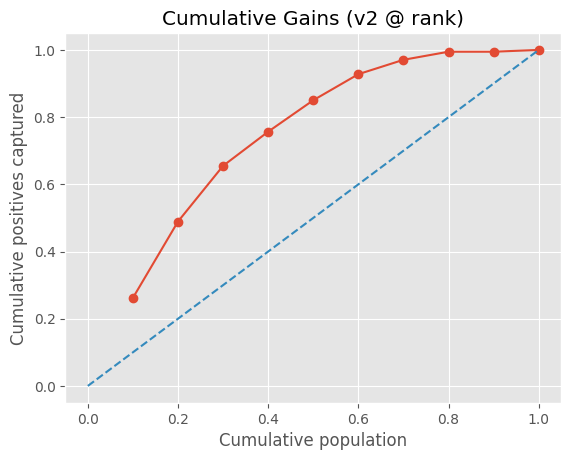

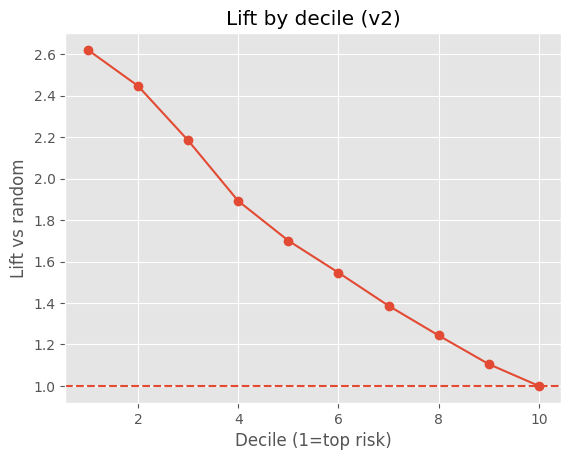

,decile,lift,gains,cum_pop
0,1,2.620321,0.262032,0.1
1,2,2.446524,0.489305,0.2
2,3,2.183601,0.655080,0.3
3,4,1.891711,0.756684,0.4
4,5,1.700535,0.850267,0.5
5,6,1.546346,0.927807,0.6
6,7,1.386555,0.970588,0.7
7,8,1.243316,0.994652,0.8
8,9,1.105169,0.994652,0.9
9,10,1.000000,1.000000,1.0


In [89]:
order = np.argsort(proba_v2)[::-1]
y_sorted = y_test.to_numpy()[order]

deciles = np.array_split(y_sorted, 10)
pos_total = y_sorted.sum()
cum_pos = np.cumsum([d.sum() for d in deciles])
cum_pop = np.arange(1, 11) / 10.0
gains   = cum_pos / pos_total
lift    = gains / cum_pop

# Cumulative gains
plt.figure()
plt.plot(cum_pop, gains, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Cumulative Gains (v2 @ rank)")
plt.xlabel("Cumulative population")
plt.ylabel("Cumulative positives captured")
plt.show()

# Lift chart
plt.figure()
plt.plot(np.arange(1,11), lift, marker="o")
plt.axhline(1.0, linestyle="--")
plt.title("Lift by decile (v2)")
plt.xlabel("Decile (1=top risk)")
plt.ylabel("Lift vs random")
plt.show()

pd.DataFrame({"decile": np.arange(1,11), "lift": lift, "gains": gains, "cum_pop": cum_pop})


In [ ]:
# Precision–Recall curve with baseline

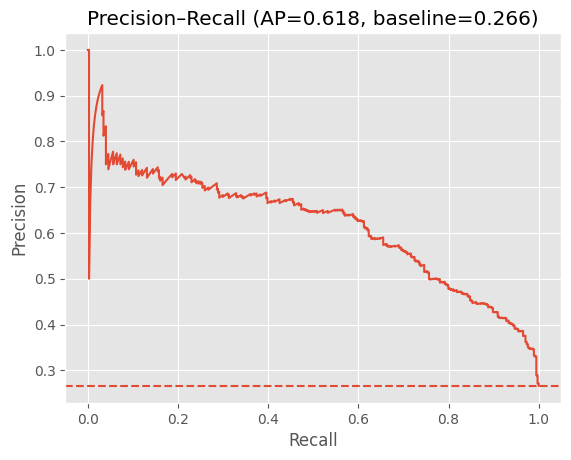

In [91]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, proba_v2)
ap = average_precision_score(y_test, proba_v2)
base = y_test.mean()

plt.figure()
plt.plot(rec, prec)
plt.axhline(base, linestyle="--")
plt.title(f"Precision–Recall (AP={ap:.3f}, baseline={base:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [ ]:
# Calibration (reliability) curve + score histogram

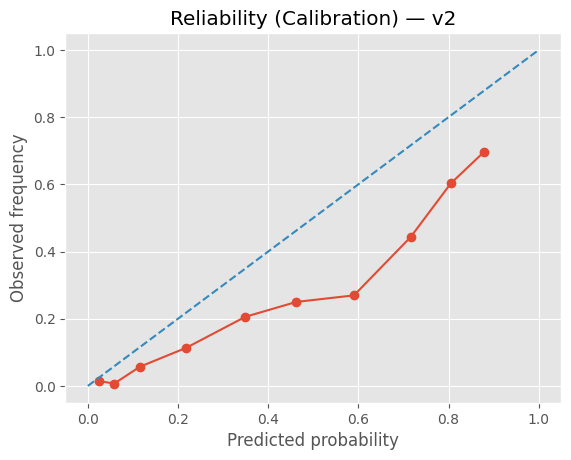

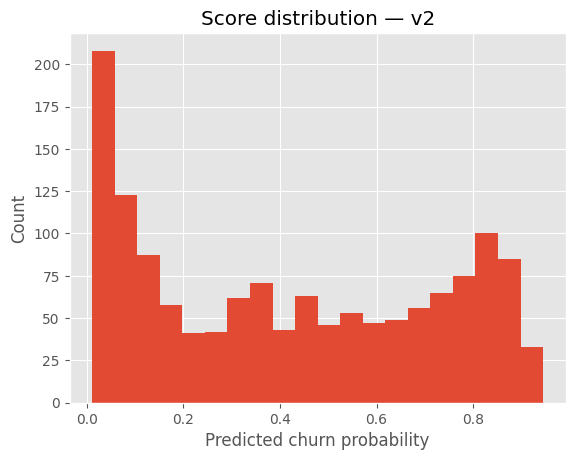

In [92]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_v2, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Reliability (Calibration) — v2")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.show()

plt.figure()
plt.hist(proba_v2, bins=20)
plt.title("Score distribution — v2")
plt.xlabel("Predicted churn probability")
plt.ylabel("Count")
plt.show()


In [ ]:
#  Error analysis (FP/FN & segment focus)

In [93]:
# Attach IDs & labels for inspection
eval_df = X_test.copy()
eval_df["customerID"] = id_test.values
eval_df["y"]    = y_test.to_numpy()
eval_df["proba"]= proba_v2
eval_df["pred"] = pred_v2

fp = eval_df.query("pred==1 and y==0").sort_values("proba", ascending=False).head(10)
fn = eval_df.query("pred==0 and y==1").sort_values("proba", ascending=True).head(10)

print("Top 10 False Positives (high proba, actually not churn):")
display(fp[["customerID","proba","Contract","tenure","MonthlyCharges"]])

print("Top 10 False Negatives (low proba, actually churn):")
display(fn[["customerID","proba","Contract","tenure","MonthlyCharges"]])

# Quick segment focus: where are we getting most true positives?
seg = (eval_df.query("pred==1 and y==1")
       .groupby("Contract")["customerID"].count()
       .sort_values(ascending=False))
print("\nTrue positives by Contract:")
display(seg)


Top 10 False Positives (high proba, actually not churn):


,customerID,proba,Contract,tenure,MonthlyCharges
3159,5150-ITWWB,0.943999,Month-to-month,3,94.85
352,4115-NZRKS,0.916702,Month-to-month,7,89.15
6574,6969-MVBAI,0.916374,Month-to-month,9,90.10
5213,7668-XCFYV,0.914225,Month-to-month,17,92.55
4150,0187-QSXOE,0.913123,Month-to-month,7,89.00
1724,7398-SKNQZ,0.910754,Month-to-month,3,94.90
5227,4060-LDNLU,0.903046,Month-to-month,7,96.20
4701,5956-YHHRX,0.898996,Month-to-month,21,104.35
886,2123-AGEEN,0.895734,Month-to-month,7,84.35
3469,9402-ORRAH,0.894242,Month-to-month,15,91.50


Top 10 False Negatives (low proba, actually churn):


,customerID,proba,Contract,tenure,MonthlyCharges
4386,3400-ESFUW,0.017712,Two year,55,57.55
4642,5458-CQJTA,0.033707,Two year,65,74.80
2894,8869-TORSS,0.085023,One year,48,60.35
6869,5906-CVLHP,0.086608,One year,45,54.15
3834,2325-ZUSFD,0.106713,One year,57,70.10
3694,1150-WFARN,0.111238,Two year,67,108.75
5086,3705-PSNGL,0.111535,One year,45,20.40
6996,4174-LPGTI,0.115959,One year,41,66.50
4698,8166-ZZTFS,0.118682,Two year,66,80.55
5581,5271-YNWVR,0.130111,Two year,68,113.15



True positives by Contract:


Contract
Month-to-month    221
One year            1
Name: customerID, dtype: int64